# Project Report

1. Motivation / Goal
2. Preparation / Setup
3. Looking at bike data only
4. Looking at weather data only
5. Bike and weather data combined
6. Conclusion

## 1. Motivation / Goal

In this notebook we are trying to explore the relationship between bike traffic and various weather measurements. There is no concrete question to be answered or phenomenon to be explained but rather this project should provide an insight into the dynamics of pedestiran traffic.
The goal is to hopefully find interesting patterns and ultimately be able to build a model using which we can predict bike traffic soly on weather data so that in the future traffic could be estimated using weather forecasts.

To accomplish this task we are using Python to combine public data provided by the German city of Münster (Bike Traffic) combined with public data provided by DWD (German Weather Data). As such our target area is only in and around the city of Münster so it should be noted that results of this analysis might not be transferable to other regions of Germany or other parts of the World. That being said, we will take this compromise in this analysis because it will give us enough insight to generate a broad overview over the topic while simplifying our process greatly.

Let's start by setting up our dependencies and data before we first look at only bike data, then only weather data, and finally the both combined.

## 2. Preparation / Setup

In [9]:
# install requirements
%pip install -r ../requirements.txt

# import requirements
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from colorsys import hls_to_rgb, rgb_to_hls

# load data
bikes = pd.read_sql_table('bikes', 'sqlite:///../data/data.sqlite')
weather = pd.read_sql_table('weather', 'sqlite:///../data/data.sqlite')

Note: you may need to restart the kernel to use updated packages.


## 3. Looking at bike data only

Our data source provided traffic in hourly slots for multiple meassurement stations located all around the city. However we are not interested in distinguishing between different stations as we only have one weather station in the city. So for all futher exploration we assume that the weather is always the same in all parts of the city. This leaves us with the sum of all bike traffic meassured, for every given hour.

Note that this number does not neccessarily reflect the exact number of people who were riding their bike during the given timeframe as there could both be routes that don't involve any tracking stations, as well as routes that involve two or more stations. Though because we have a large number of trackers placed in all parts of the city, the number should stongly corrolate with the traffic generated by bikes. That's why we're going to call it **traffic** from now on.

So instead of thinking about the traffic number as people per hour, we have to think about it as "perceived traffic" (standing next to a bike lane and watching people pass by) or "time spent on bikes" (as in few people riding long distances result in the same number as many people riding short distances). This distinction is very important and should be kept in mind going forward.

---

To get started we want to look at bike data isolated, leaving weather out of the equation for now. This leaves us with only one other metric to categorize and compare bike data to: time.

We'll group the traffic into different buckets for visualization.

In [10]:
byDate20 = {}
byDate21 = {}
byHour = {}
byWeekday = {}
byMonth = {}

for idx, row in bikes.iterrows():
    count = row['count']
    date, hour = row['id'].split(' ')
    year, month, day = date.split('-')

    date_without_year = month + '-' + day
    if not date_without_year in byDate20:
        byDate20[date_without_year] = 0
    if not date_without_year in byDate21:
        byDate21[date_without_year] = 0
    if year == '2020':
        byDate20[date_without_year] += count
    else:
        byDate21[date_without_year] += count

    if not hour in byHour:
        byHour[hour] = 0
    byHour[hour] += count

    weekday = str(datetime.date(int(year), int(month), int(day)).weekday())
    if not weekday in byWeekday:
        byWeekday[weekday] = 0
    byWeekday[weekday] += count

    if not month in byMonth:
        byMonth[month] = 0
    byMonth[month] += count

Data is loaded, let's get started by simply plotting the total traffic (sum) of any given day of the year. Because our dataset exists of two years (2020 + 2021), we will see two lines, one for each year.

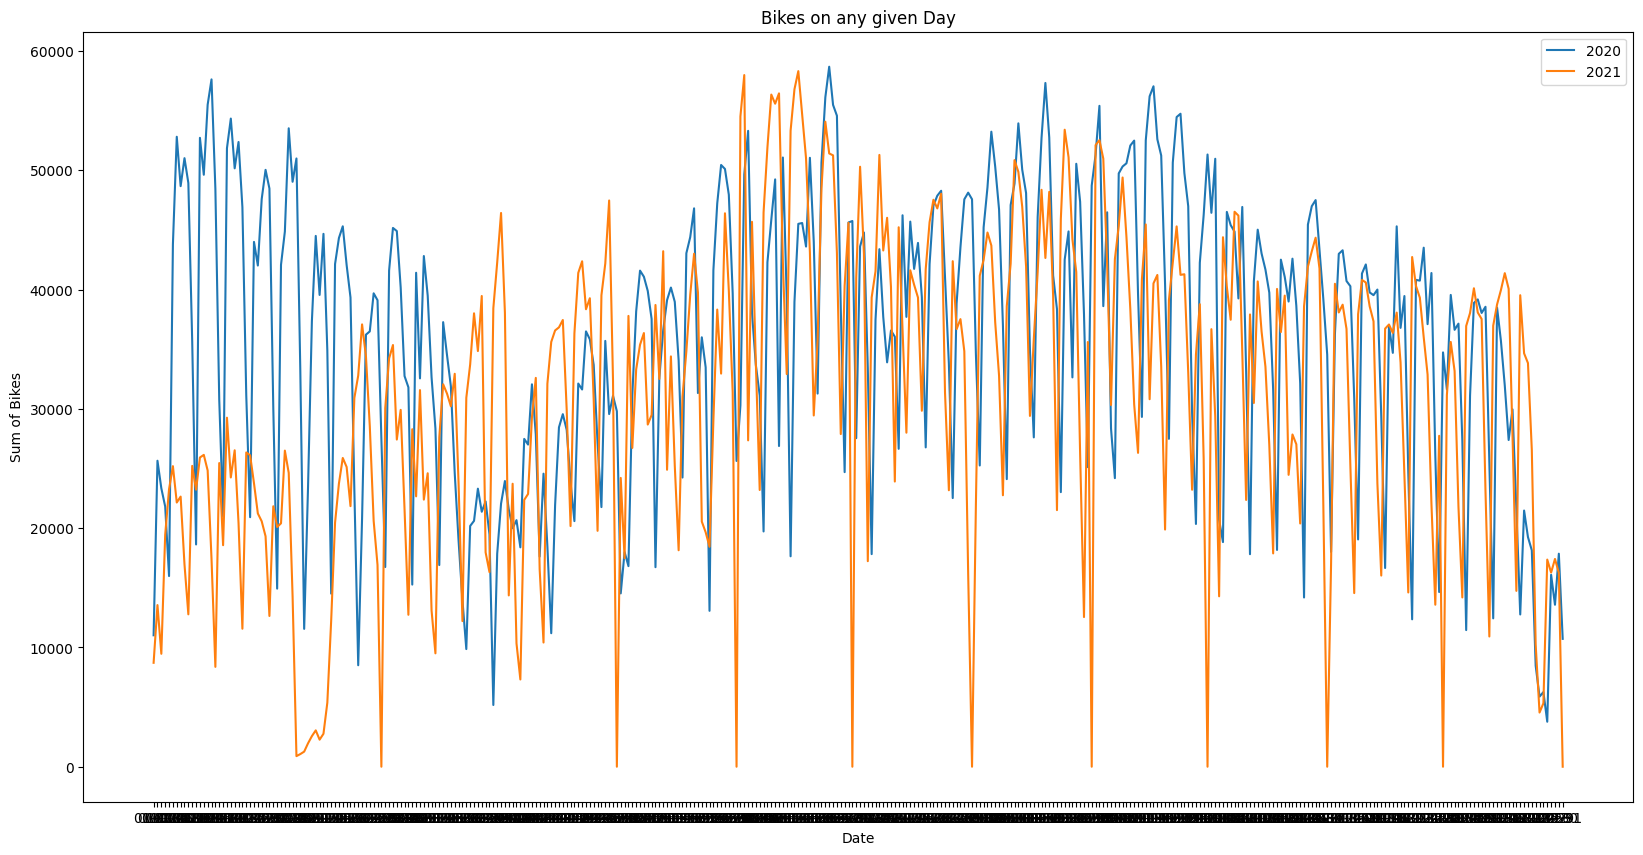

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(byDate20.keys(), byDate20.values(), label="2020")
plt.plot(byDate21.keys(), byDate21.values(), label="2021")
plt.xlabel("Date")
plt.ylabel("Sum of Bikes")
plt.title("Bikes on any given Day")
plt.legend()
plt.show()

As expected this is not very telling. Let's try to find patterns anyway:
1. It looks like there is a positive trend in the warmer months (middle of the graph) while colder months (especially in 2021) seem to have less traffic overall)
2. It looks like the number is varying a lot per week.

First let's see if we can confirm guess number 1 by looking at total traffic per month:

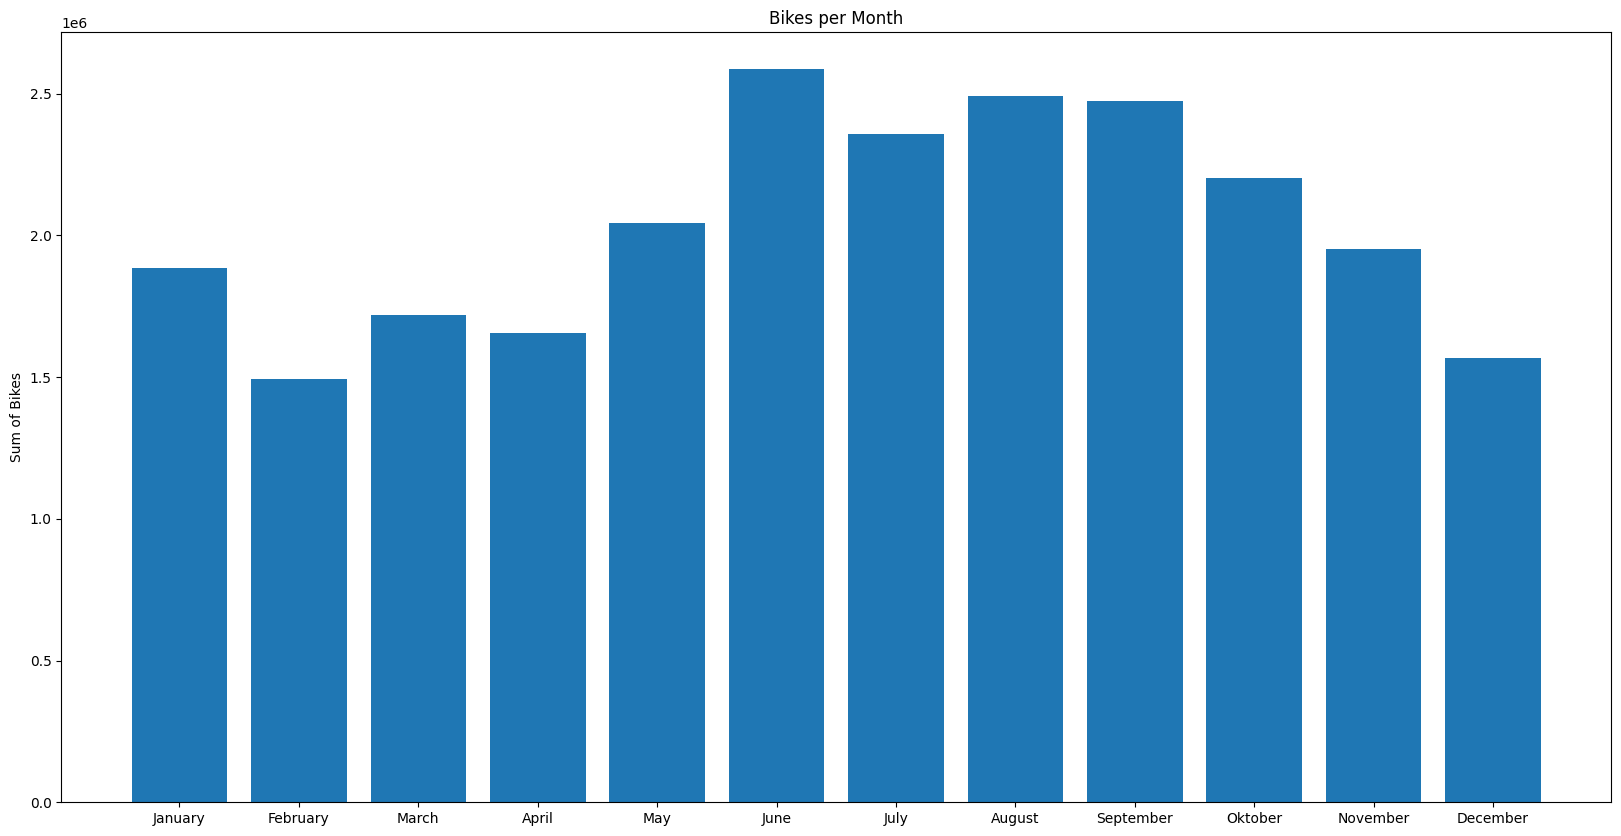

In [12]:
month_names = [ 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'Oktober', 'November', 'December' ]

plt.figure(figsize=(20, 10))
plt.bar([month_names[int(x)-1] for x in list(byMonth.keys())], byMonth.values())
plt.ylabel("Sum of Bikes")
plt.title("Bikes per Month")
plt.show()

And yes we can confirm that during summer we have on average around 25% more traffic than during winter months.

To build on this let's already make another guess, we'll have to verify or deny later: Summer months are busier because of the warmer temperatures.

Next up let's look at our second guess from earlier: Traffic by weekday

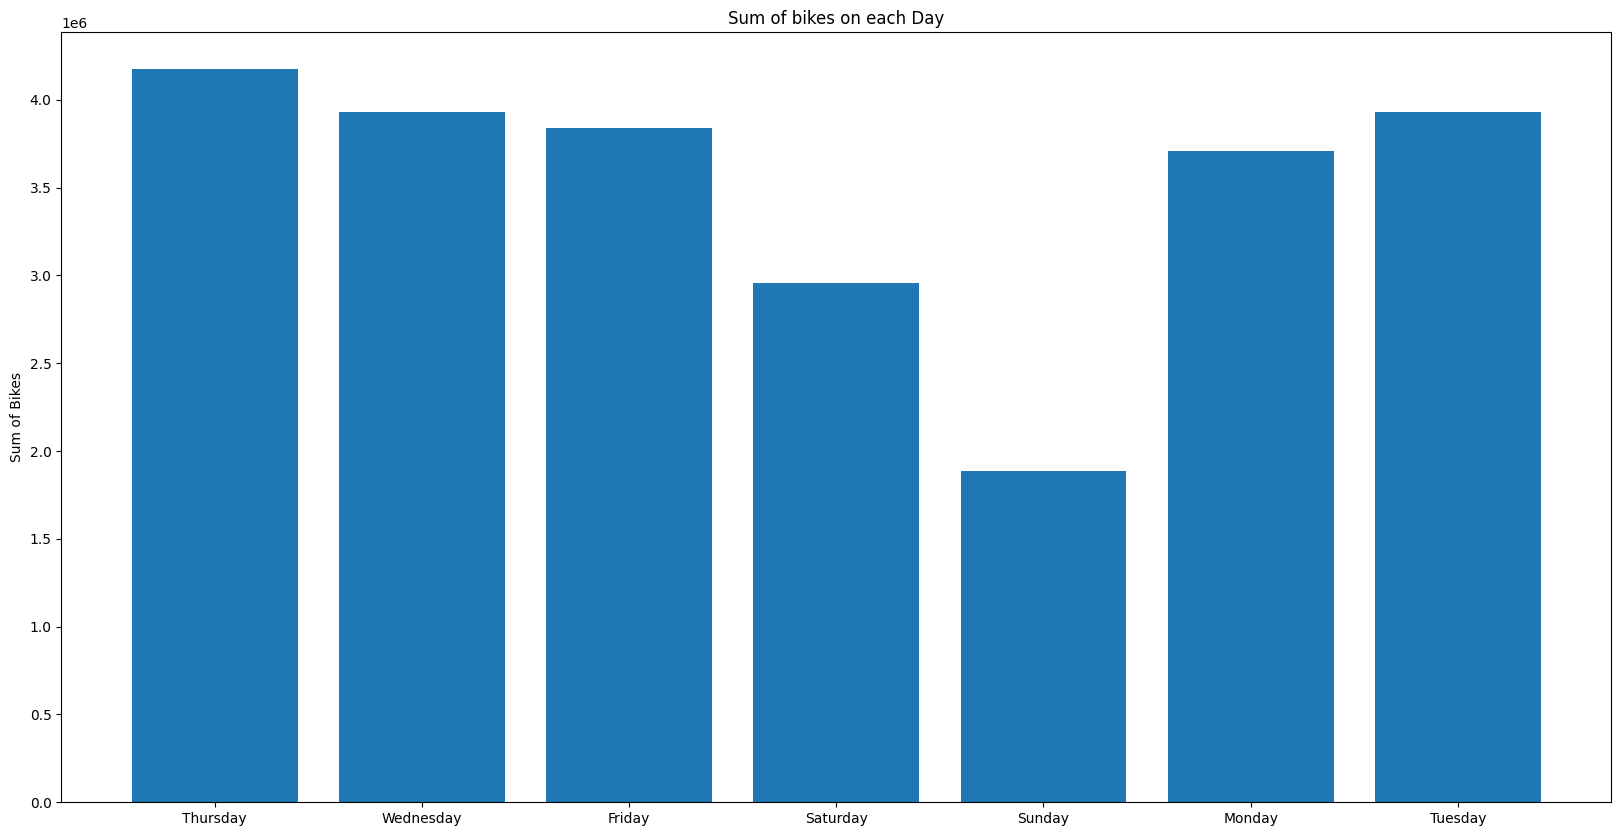

In [13]:
day_names = [ 'Monday', 'Tuesday', 'Thursday', 'Wednesday', 'Friday', 'Saturday', 'Sunday' ]

plt.figure(figsize=(20, 10))
plt.bar([day_names[int(x)] for x in list(byWeekday.keys())], byWeekday.values())
plt.ylabel("Sum of Bikes")
plt.title("Sum of bikes on each Day")
plt.show()

Interestingly the weekend (especially Sunday) is less then half as busy the average workday. Apparently a lot of people use their bikes more as a means of transportation, to get to places like work or shopping, rather than a hobby activity or sport to do in their free time.

Finally let us take a look at which hours are the busiest:

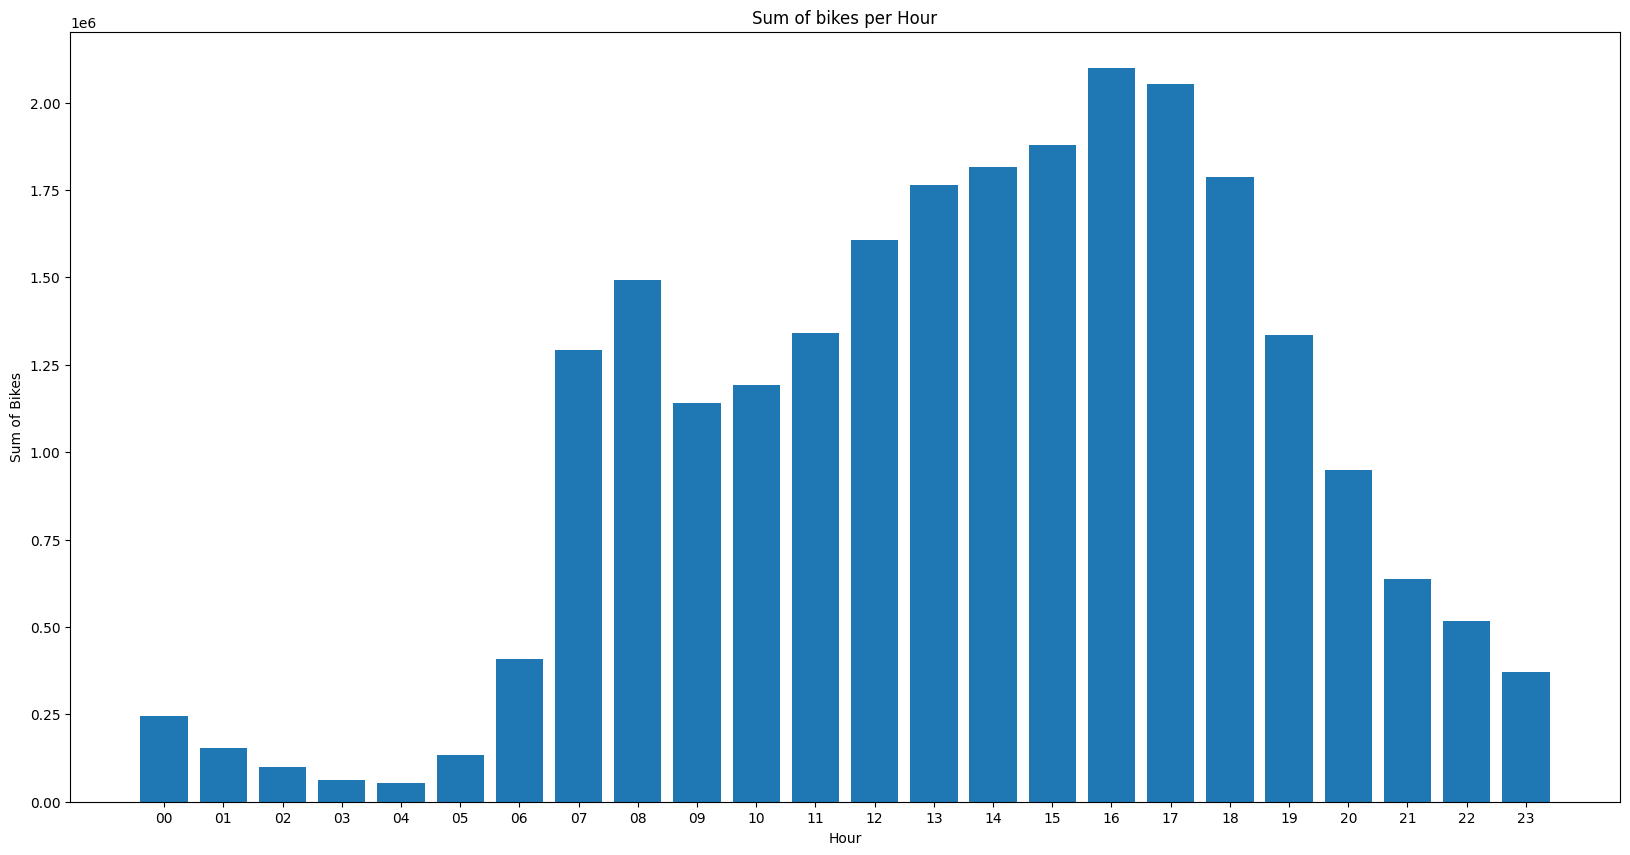

In [14]:
plt.figure(figsize=(20, 10))
plt.bar(byHour.keys(), byHour.values())
plt.xlabel("Hour")
plt.ylabel("Sum of Bikes")
plt.title("Sum of bikes per Hour")
plt.show()

As would be expected, traffic at night is a lot lower than during daytime. Additionally it is apparent that between 7:00 and 8:00 in the morning and around 16:00 to 18:00 in the evening are peak times. This would corrolate with our theory from earlier that stated a lot of people use their bike to get from and to work as those times line up with usual office hours.

Let's check out one last graph, this one is not about bike counts on yet another time scale, but instead we're looking at how traffic numbers on a daily basis are distributed. As we have noticed from earlier graphs, there is almost always some level of traffic, no matter the time of day or month in the year. We want to find out what this baseline traffic is and how likely certain daily scores are. The kind of question we want to be able to answer is: "What is the chance that for a randomly selected day, the traffic is below 200" or similar.

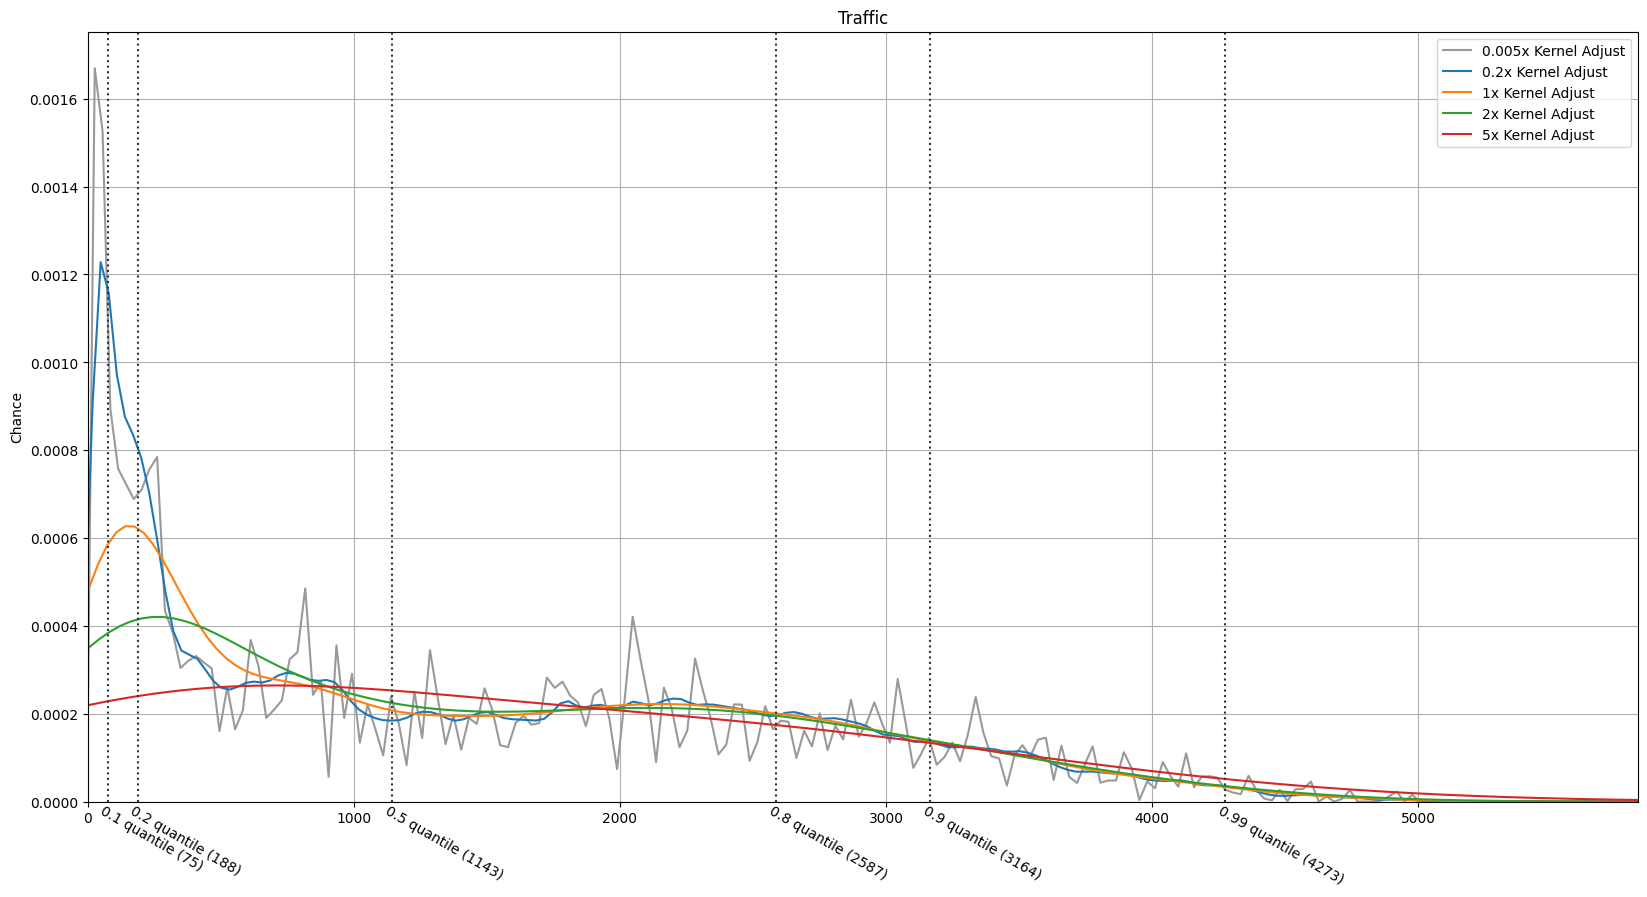

In [15]:
plt.figure(figsize=(20, 10))
plt.xlim(0, np.max(bikes['count']))

sns.kdeplot(bikes['count'], bw_adjust=0.005, label='0.005x Kernel Adjust', color='0.6')
sns.kdeplot(bikes['count'], bw_adjust=0.2, label='0.2x Kernel Adjust')
sns.kdeplot(bikes['count'], bw_adjust=1, label='1x Kernel Adjust')
sns.kdeplot(bikes['count'], bw_adjust=2, label='2x Kernel Adjust')
sns.kdeplot(bikes['count'], bw_adjust=5, label='5x Kernel Adjust')

q01 = bikes['count'].quantile(q=0.1)
plt.axvline(x=q01, color='.2', linestyle='dotted')
plt.text(q01-50, 0, ' 0.1 quantile (' + str(round(q01)) + ')', rotation=-30, va='top')
q02 = bikes['count'].quantile(q=0.2)
plt.axvline(x=q02, color='.2', linestyle='dotted')
plt.text(q02-50, 0, ' 0.2 quantile (' + str(round(q02)) + ')', rotation=-30, va='top')
q05 = bikes['count'].quantile(q=0.5)
plt.axvline(x=q05, color='.2', linestyle='dotted')
plt.text(q05-50, 0, ' 0.5 quantile (' + str(round(q05)) + ')', rotation=-30, va='top')
q08 = bikes['count'].quantile(q=0.8)
plt.axvline(x=q08, color='.2', linestyle='dotted')
plt.text(q08-50, 0, ' 0.8 quantile (' + str(round(q08)) + ')', rotation=-30, va='top')
q09 = bikes['count'].quantile(q=0.9)
plt.axvline(x=q09, color='.2', linestyle='dotted')
plt.text(q09-50, 0, ' 0.9 quantile (' + str(round(q09)) + ')', rotation=-30, va='top')
q099 = bikes['count'].quantile(q=0.99)
plt.axvline(x=q099, color='.2', linestyle='dotted')
plt.text(q099-50, 0, ' 0.99 quantile (' + str(round(q099)) + ')', rotation=-30, va='top')

plt.grid()

plt.ylabel('Chance')
plt.xlabel('')
plt.title('Traffic')
plt.legend()
plt.show()

Using this data we can answer the example question from earlier: About 20%.
The 0.2 quantile is at 188, so the percentage for 200 must be slightly higher.

So much for bike data for now. Let's also briefly take a look at our weather data.

## 4. Looking at weather data only

For our weather data, we again have datapoints plotted by hour. Only this time we have a lot more data per hour than just one field as with the bikes.

In [16]:
# an example row
weather.loc[weather['date'] == 2022010101]

,date,clouds_vn,ewind_fx911,temp_tt_tu,temp_rf_tu,vis_v_vv,prec_r1,wind_f,wind_d
17542,2022010101,7,7.2,12.8,86.0,20000.0,0.0,4.6,240


column | value
---|---
date | the date and time of this datapoint in format YYYYMMDDhh
clouds_vn | amounts of clouds with 1 being the least and 8 being the most
ewind_fx911 | no information provided by dwd. dataset is called "extreme winds" thus higher numbers most likely indicate higher wind speeds
temp_tt_tu | air temperature in °C, measured 2m above ground
temp_rf_tu | relative humidity in %
vis_v_vv | view distance in m
prec_r1 | precipitation in mm
wind_f | average wind speed in m/s
wind_d | average wind direction in °, with 0° being north

Let's first prepare some data to look at afterwards.

In [17]:
weather['date_hour'] = weather['date'] % 100
weather['date_day'] = np.floor(weather['date'] / 100).astype(int) % 100
weather['date_month'] = np.floor(weather['date'] / 10000).astype(int) % 100
weather['date_year'] = np.floor(weather['date'] / 1000000).astype(int) % 10000
weather['date_noyear'] = weather['date'] % 10000000
weather['date_noyear_c'] = weather['date_month']*31*24 + weather['date_day']*24 + weather['date_hour']
weather['date_monthday'] = weather['date_month']*31 + weather['date_day']

filter_is_2020 = weather['date_year'] == 2020
filter_is_2021 = weather['date_year'] == 2021
filter_is_right_year = weather['date_year'].isin([ 2020, 2021 ])

Now we'll start with some seemingly random views at our data to get an overview over what we got to work with. Please note that we will only be looking at the years 2020 and 2021, as we only have bike traffic data for these years. We are not interested in older or more recent data.

We will begin with the average temperature throughout the day:

/tmp/ipykernel_4620/3747209241.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = weather[filter_is_right_year][weather['date_month']==month].groupby('date_hour').mean()
/tmp/ipykernel_4620/3747209241.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = weather[filter_is_right_year][weather['date_month']==month].groupby('date_hour').mean()
/tmp/ipykernel_4620/3747209241.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = weather[filter_is_right_year][weather['date_month']==month].groupby('date_hour').mean()
/tmp/ipykernel_4620/3747209241.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = weather[filter_is_right_year][weather['date_month']==month].groupby('date_hour').mean()
/tmp/ipykernel_4620/3747209241.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = weather[filter_is_right_year][weather[

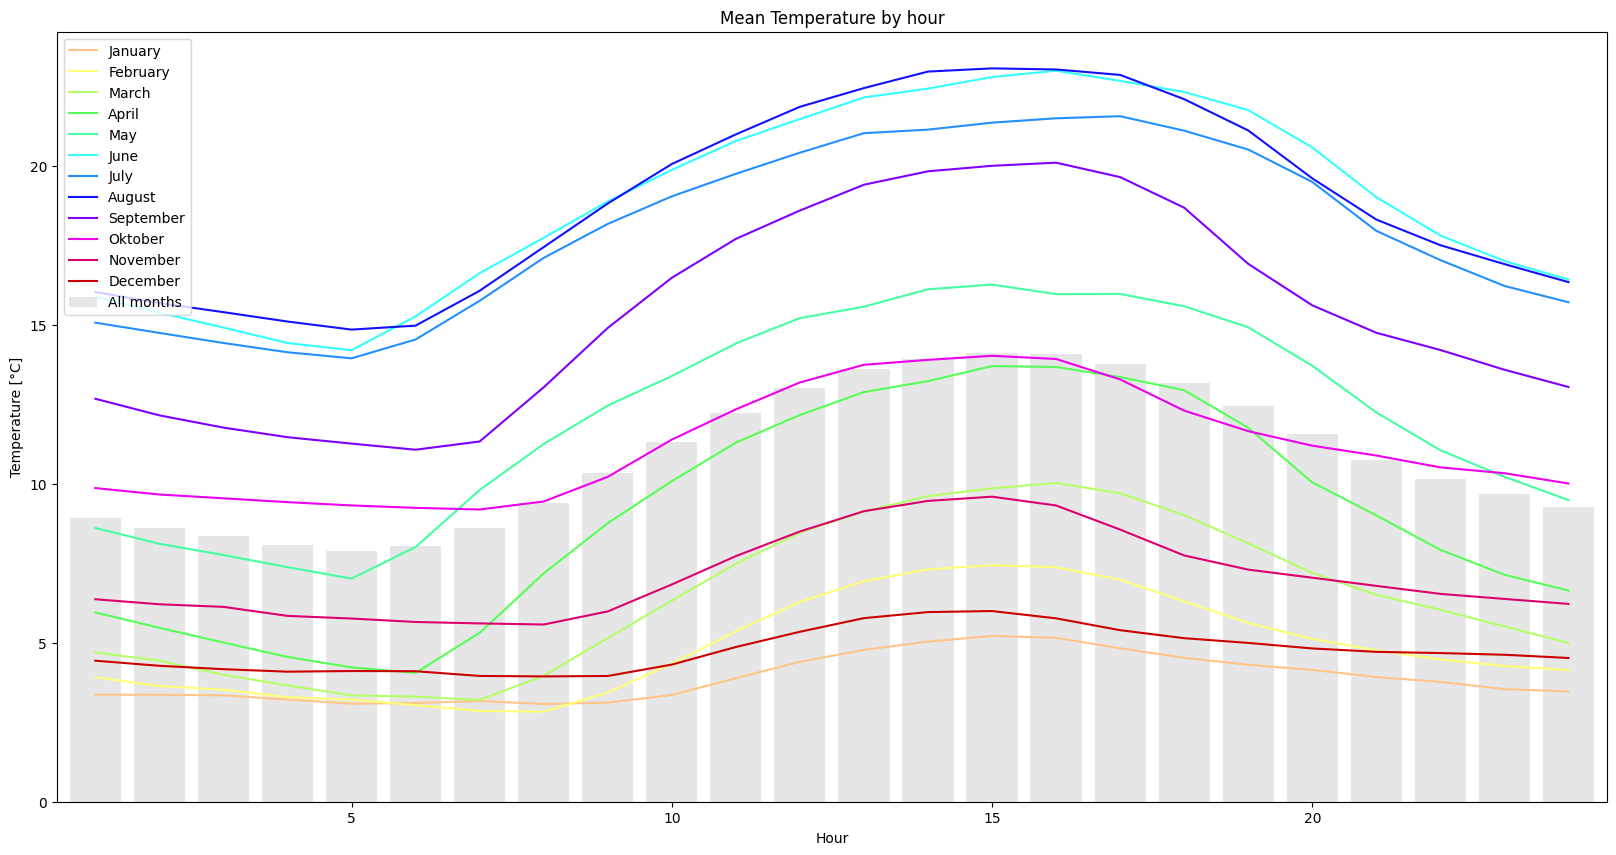

In [18]:
plt.figure(figsize=(20, 10))
data = weather[filter_is_right_year].groupby('date_hour').mean()
plt.bar(range(1,25), data['temp_tt_tu'], color='0.9', label='All months')
for month in range(1, 13):
  data = weather[filter_is_right_year][weather['date_month']==month].groupby('date_hour').mean()
  plt.plot(range(1, 25), data['temp_tt_tu'], label=month_names[month-1], color=hls_to_rgb(month/12, 0.8 - month/30, 1))
plt.xlim(0.4, 24.6)
plt.xlabel("Hour")
plt.ylabel("Temperature [°C]")
plt.title("Mean Temperature by hour")
plt.legend()
plt.show()

Next up all recorded temperatures in the two years we're looking at.

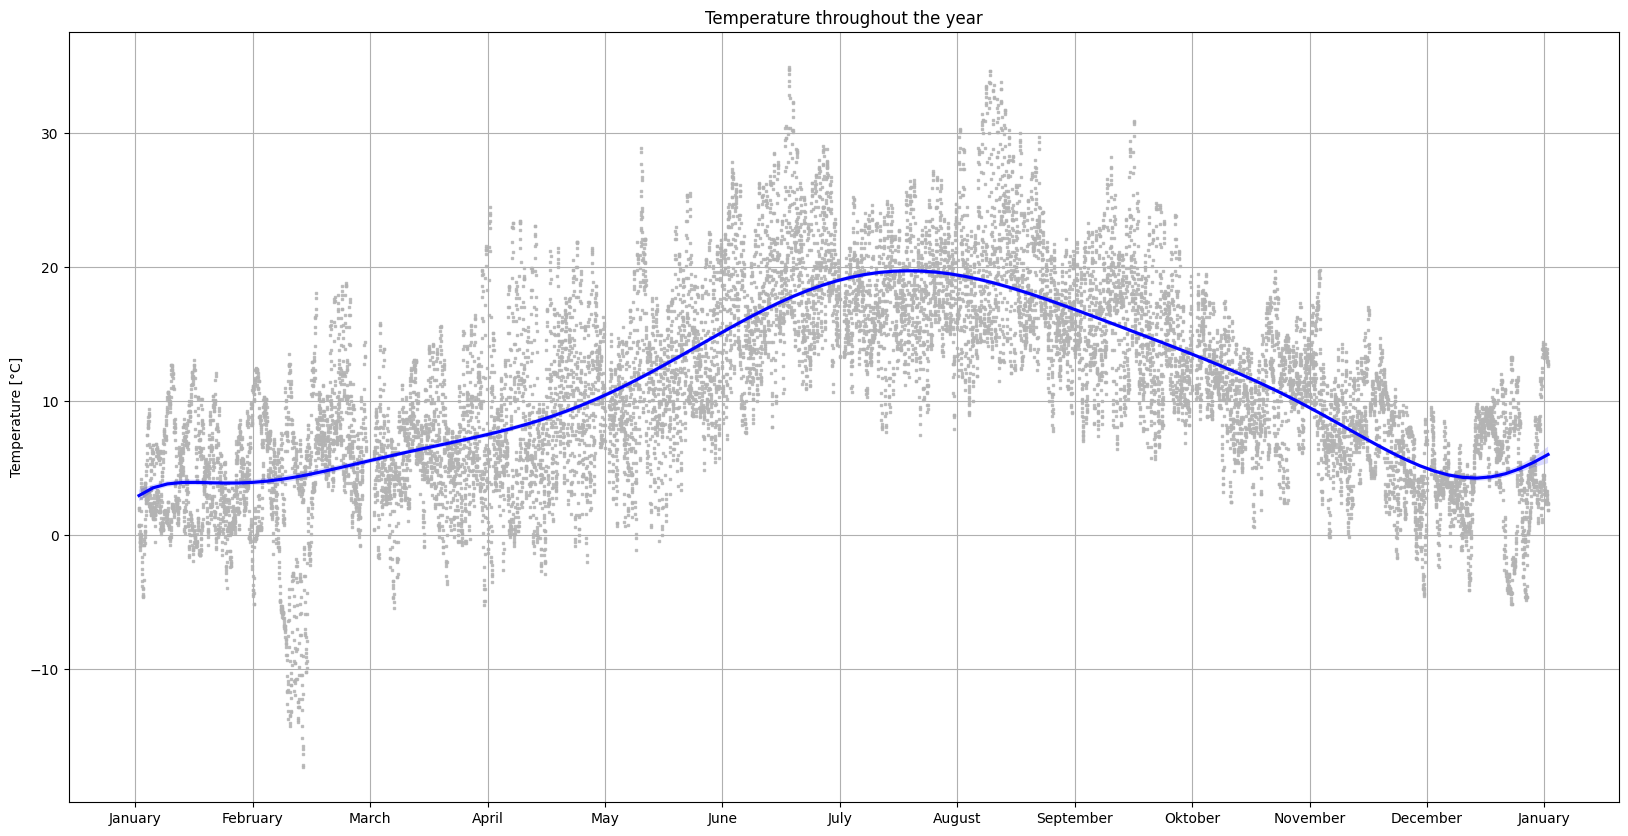

In [19]:
plt.figure(figsize=(20, 10))

data = weather[filter_is_right_year].groupby('date_noyear', as_index=False).mean()
plt.xticks([ x*31*24 for x in range(1, 14) ], [*month_names, month_names[0]])
sns.regplot(x=data['date_noyear_c'], y=data['temp_tt_tu'], marker=',', color='blue', order=10, ci=90, scatter_kws={'s':1, 'color':'.7'})

plt.xlabel("")
plt.ylabel("Temperature [°C]")
plt.title("Temperature throughout the year")
plt.grid(True)
plt.show()

Now onto precipitation throughout the year. The blue bars are total precipitation per day, the gray bars are the average daily amount within each month.

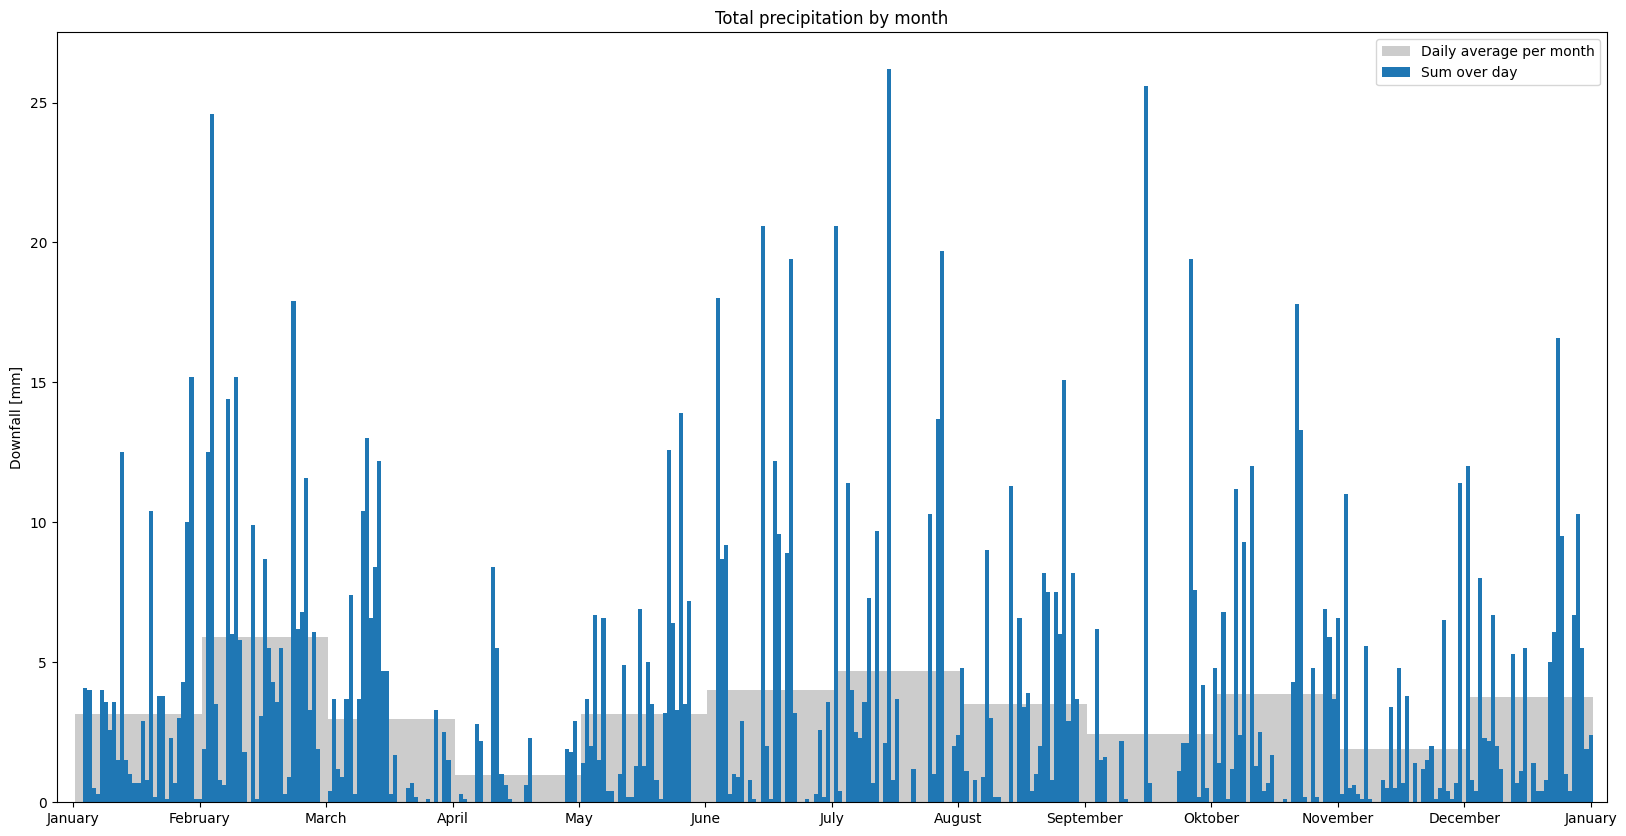

In [20]:
plt.figure(figsize=(20, 10))

data = weather[filter_is_right_year]
data = data[data['prec_r1'] >= 0]

plt.xticks([ x*31 for x in range(1, 14) ], [*month_names, month_names[0]])
plt.xlim(31-4, 31*13+4)

data_1 = data.groupby('date_month', as_index=False).sum()
plt.bar(data_1['date_month']*31 + 16, data_1['prec_r1'].abs()/31, color='0.8', width=31, label='Daily average per month')

data_2 = data.groupby('date_monthday', as_index=False).sum()
plt.bar(data_2['date_monthday'], data_2['prec_r1'].abs(), width=1, label='Sum over day')

plt.xlabel("")
plt.ylabel("Downfall [mm]")
plt.title("Total precipitation by month")
plt.legend()
plt.show()

Let's also quickly look at view distance and humidity as they could also have a huge impact on how likely people are to use the bike.

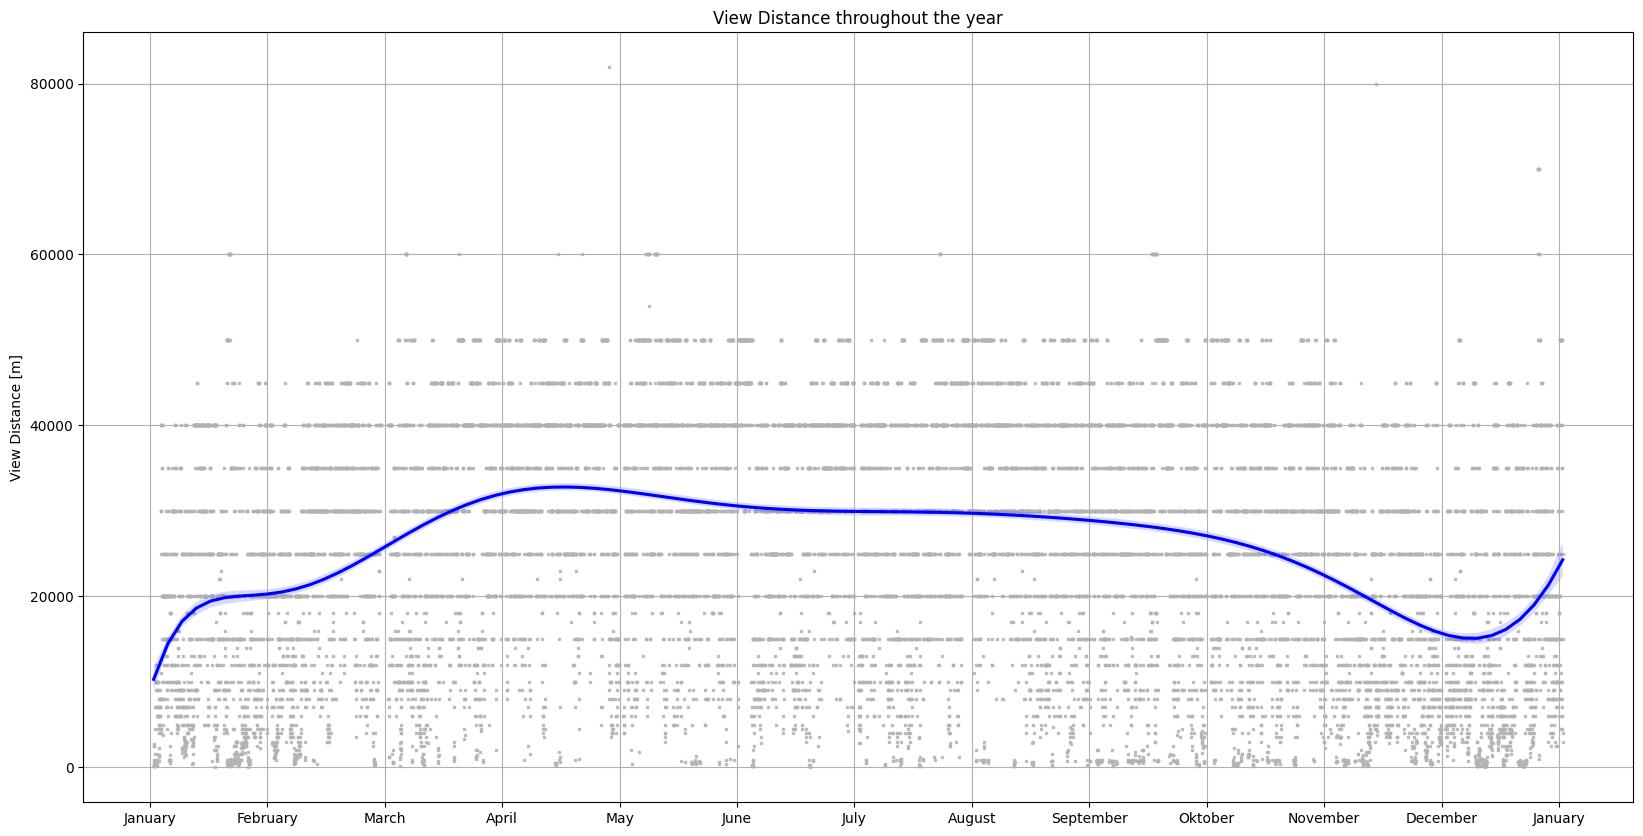

In [21]:
plt.figure(figsize=(20, 10))

data = weather[filter_is_right_year].groupby('date_noyear', as_index=False).mean()
plt.xticks([ x*31*24 for x in range(1, 14) ], [*month_names, month_names[0]])
sns.regplot(x=data['date_noyear_c'], y=data['vis_v_vv'], marker=',', color='blue', order=10, ci=90, scatter_kws={'s':1, 'color':'.7'})

plt.xlabel("")
plt.ylabel("View Distance [m]")
plt.title("View Distance throughout the year")
plt.grid(True)
plt.show()

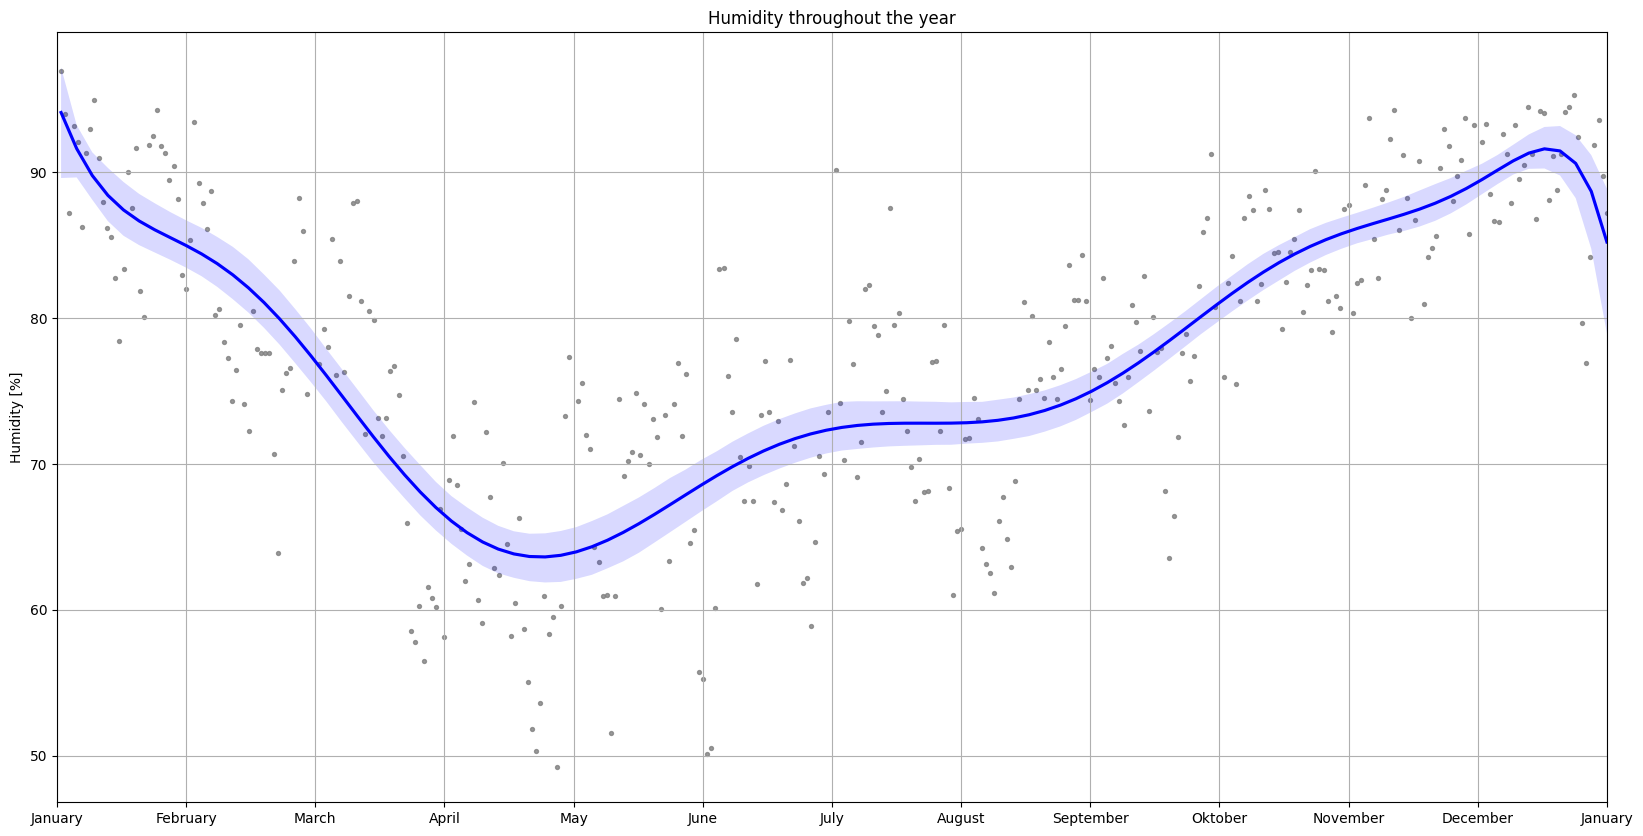

In [22]:
plt.figure(figsize=(20, 10))

data = weather[filter_is_right_year].groupby('date_monthday', as_index=False).mean()
plt.xticks([ x*31 for x in range(1, 14) ], [*month_names, month_names[0]])
plt.xlim(31, 31*13)
sns.regplot(x=data['date_monthday'], y=data['temp_rf_tu'], marker='.', color='blue', order=10, ci=90, scatter_kws={'s':32, 'color':'.5'})

plt.xlabel("")
plt.ylabel("Humidity [%]")
plt.title("Humidity throughout the year")
plt.grid(True)
plt.show()

As is to be expected, average view distance goes down a little during the colder seasons due to fog and snow.
Humidity on the other hand is the lowest during spring and very high during snow season.

Let's keep these findings in mind while finally going to the most interesting section: Combining the two datasets.

## 5. Bike and weather data combined

First let's merge the two datasets into one. This is very easy as both have a time based index we carefully prepared to be in the same format.

In [28]:
merged = pd.merge(weather, bikes, on='date', how='inner')
merged = merged.rename(columns={ 'count': 'bike_count' })
merged = merged.drop('id', axis=1)

def plot_bikes_and(column: str, label: str, title: str, data = merged[filter_is_right_year]):
  plt.figure(figsize=(20, 10))
  plt.xticks(np.arange(-20, 40, 5), np.arange(-20, 40, 5))

  plt.ylim(0, np.max(data['bike_count']))

  sns.regplot(x=data[column], y=data['bike_count'], marker='.', color='blue', order=10, ci=90, scatter_kws={'s':32, 'color':'0.5'})

  plt.xlabel(label)
  plt.ylabel("Bike Count")
  plt.title(title)
  plt.grid(True)
  plt.show()

merged.head(1)

/tmp/ipykernel_4620/3793009589.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  def plot_bikes_and(column: str, label: str, title: str, data = merged[filter_is_right_year]):


,date,clouds_vn,ewind_fx911,temp_tt_tu,temp_rf_tu,vis_v_vv,prec_r1,wind_f,wind_d,date_hour,date_day,date_month,date_year,date_noyear,date_noyear_c,date_monthday,bike_count
0,2020010100,8,2.1,0.7,100.0,200.0,0.0,1.1,170,0,1,1,2020,10100,768,32,327


We will start by doing some basic 2d plots of one weather feature each and bike count on the x and y axis respectively. Let's start with temperature.

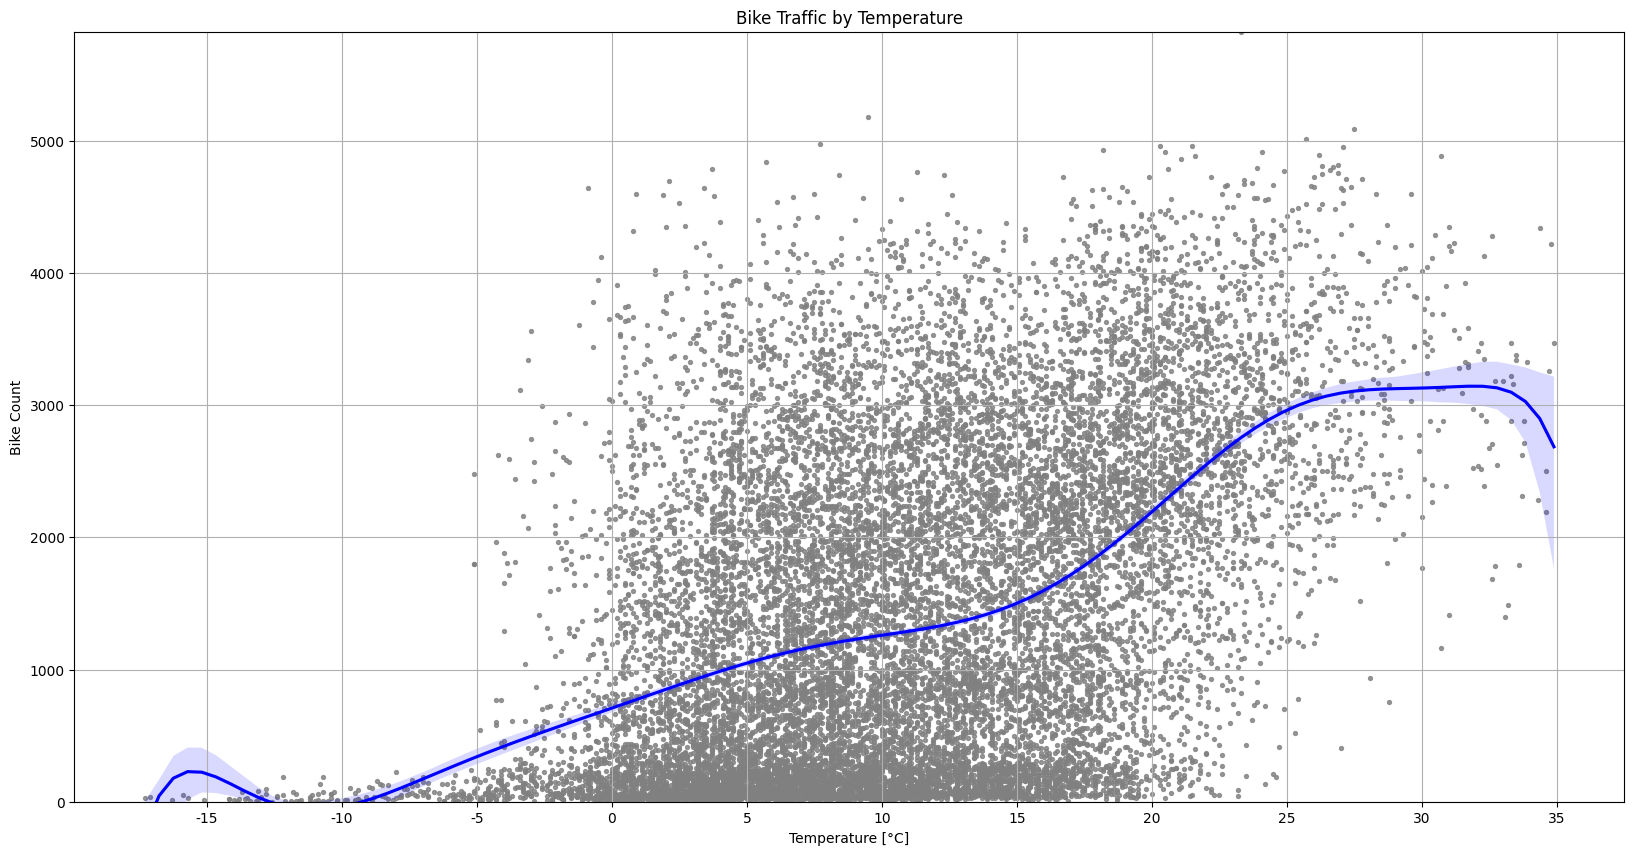

In [31]:
plot_bikes_and('temp_tt_tu', 'Temperature [°C]', 'Bike Traffic by Temperature')

As was to be expected, hotter temperatures encourage more biking. The highest mean traffic is located between 25 and 33 °C, with the trend decreasing for temperatures hotter than 33°C. Biking is not fun when it's too hot, so it's nice to see this reflected in our dataset as well. Interesting to look at is the small peek at -15°C.

Next up we're going to use the same model but this time compare it to precipitation:

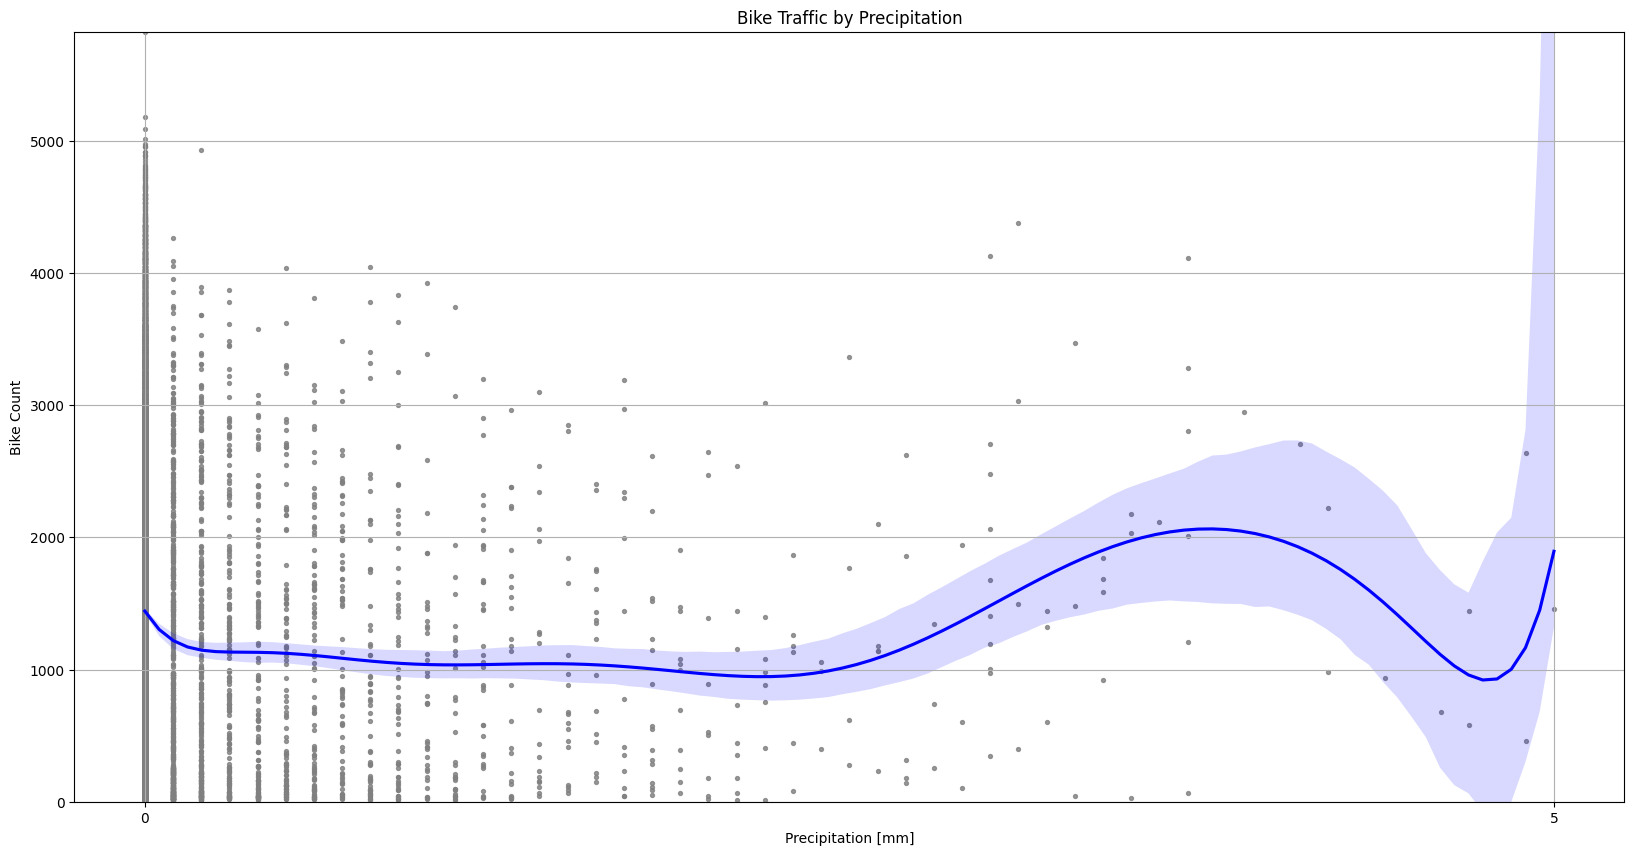

In [37]:
data = merged[merged['prec_r1'] > -900]
data = data[data['prec_r1'] <= 5]
plot_bikes_and('prec_r1', 'Precipitation [mm]', 'Bike Traffic by Precipitation', data)

Looking at the very left of the graph we can see a subtle drop in traffic for when there is any amount of precipitation (> 0mm) compared to no precipitation at all (= 0mm). The traffic doesn't drop much further down the more wet it gets however. So the deciding factor on whether or not to use the bike that day seems to be mostly "do we have downfall?" and less "how much downfall do we have?". For those who even care at all, that is, most people seem rather unimpressed by some light rain.

The weird movements the regression line makes to the right of the graph is due to a lack of data with high precipitation, as is indicated by the very broad confidence interval, and as such can be ignored.

We'll continue with wind speeds.

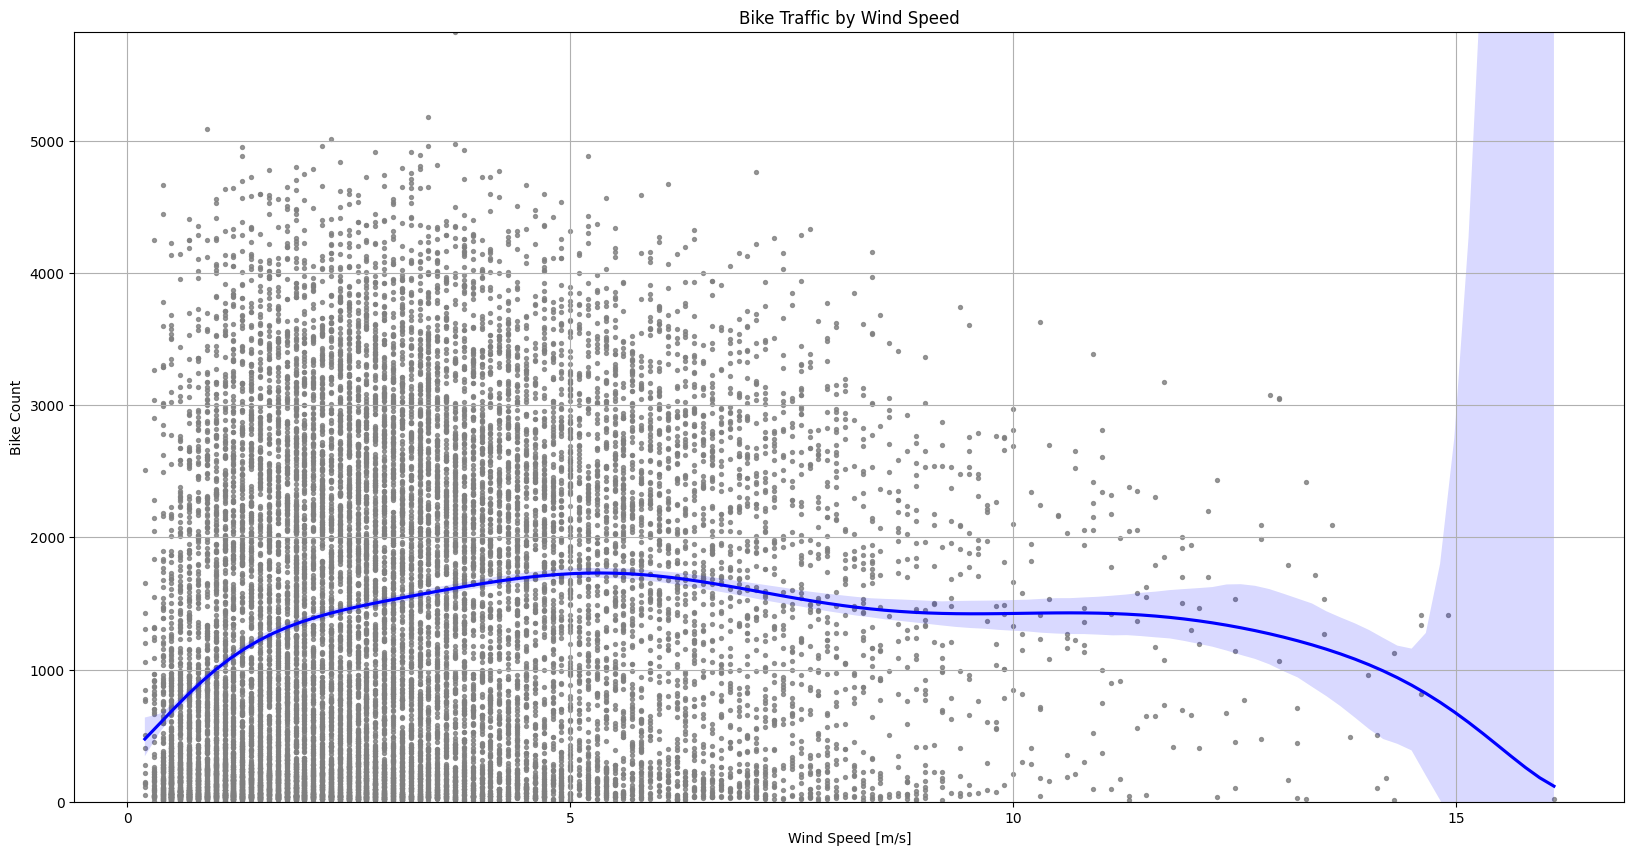

In [47]:
data = merged[merged['wind_f'] > -1]
plot_bikes_and('wind_f', 'Wind Speed [m/s]', 'Bike Traffic by Wind Speed', data)

TODO KOMMENTAR

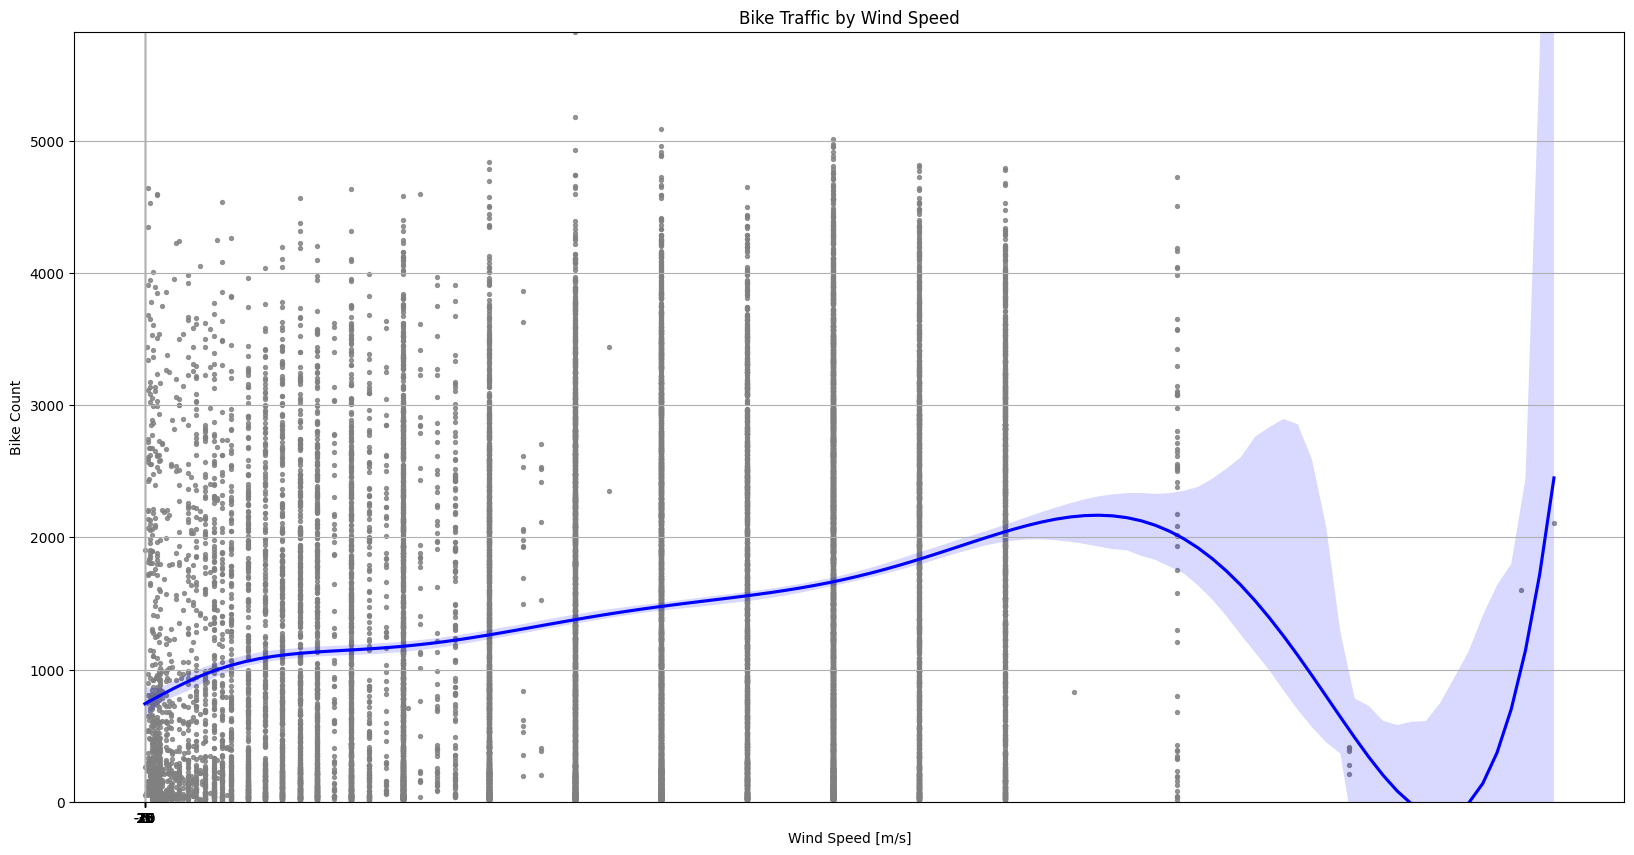

In [49]:
data = merged[merged['vis_v_vv'] > -1]
plot_bikes_and('vis_v_vv', 'View Distance [m]', 'Bike Traffic by View Distance', data)

TODO KOMMENTAR

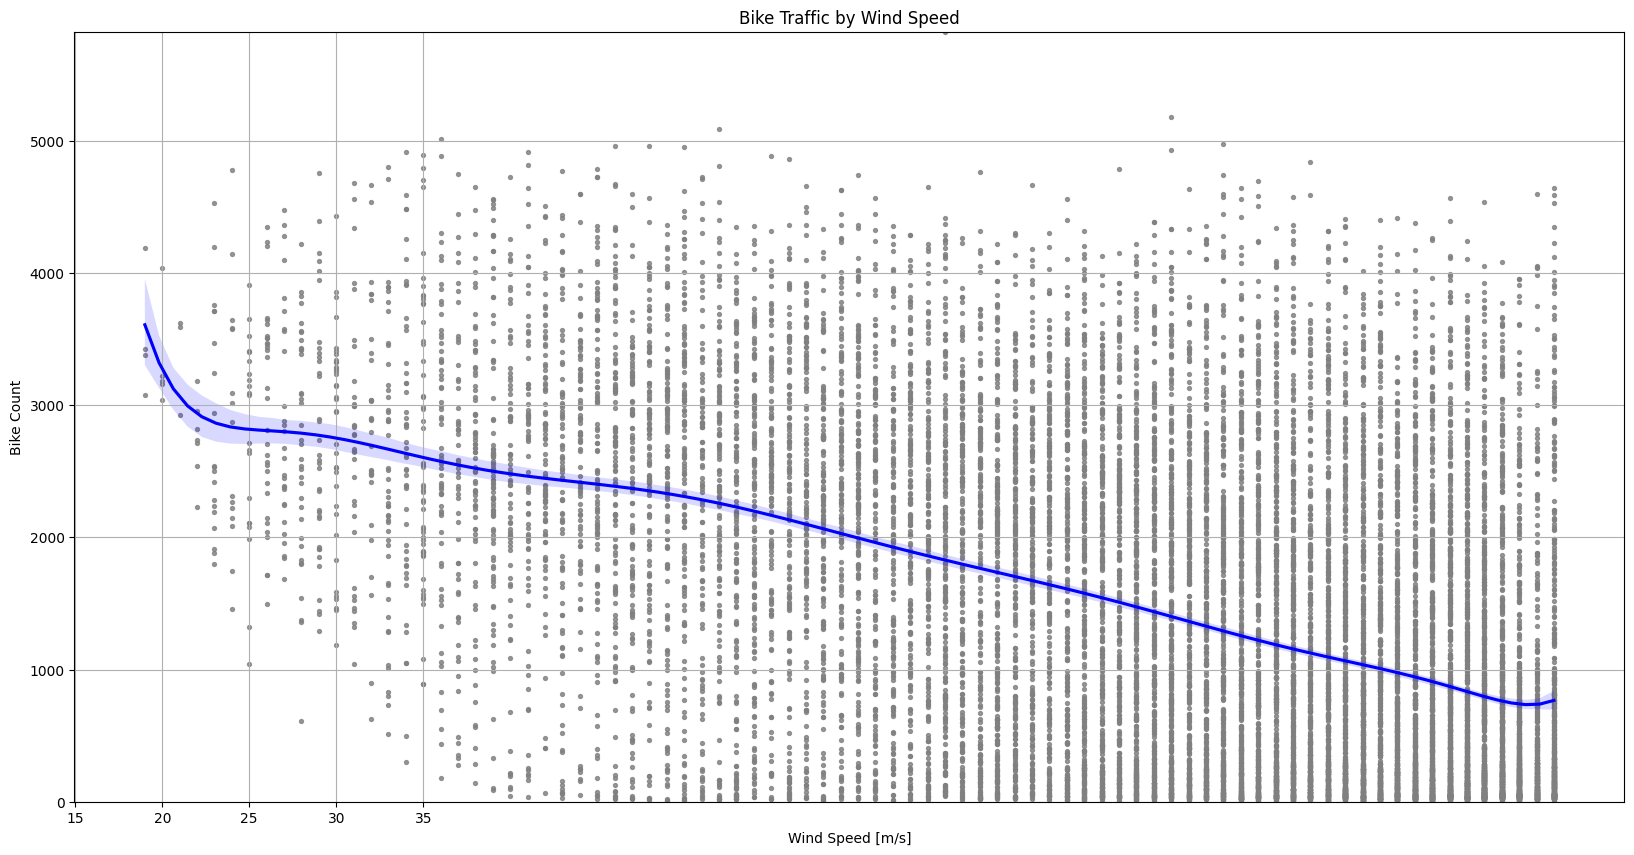

In [52]:
data = merged[merged['temp_rf_tu'] > -1]
plot_bikes_and('temp_rf_tu', 'Relative Humidity [%]', 'Bike Traffic by Humidity', data)

TODO KOMMENTAR

/home/coder/.local/lib/python3.8/site-packages/seaborn/regression.py:254: RankWarning: Polyfit may be poorly conditioned
  yhat = reg_func(x, y)
/home/coder/.local/lib/python3.8/site-packages/seaborn/algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/coder/.local/lib/python3.8/site-packages/seaborn/algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/coder/.local/lib/python3.8/site-packages/seaborn/algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/coder/.local/lib/python3.8/site-packages/seaborn/algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/coder/.local/lib/python3.8/site-packages/seaborn/algorithms.py:98: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/home/coder/.local/lib/py

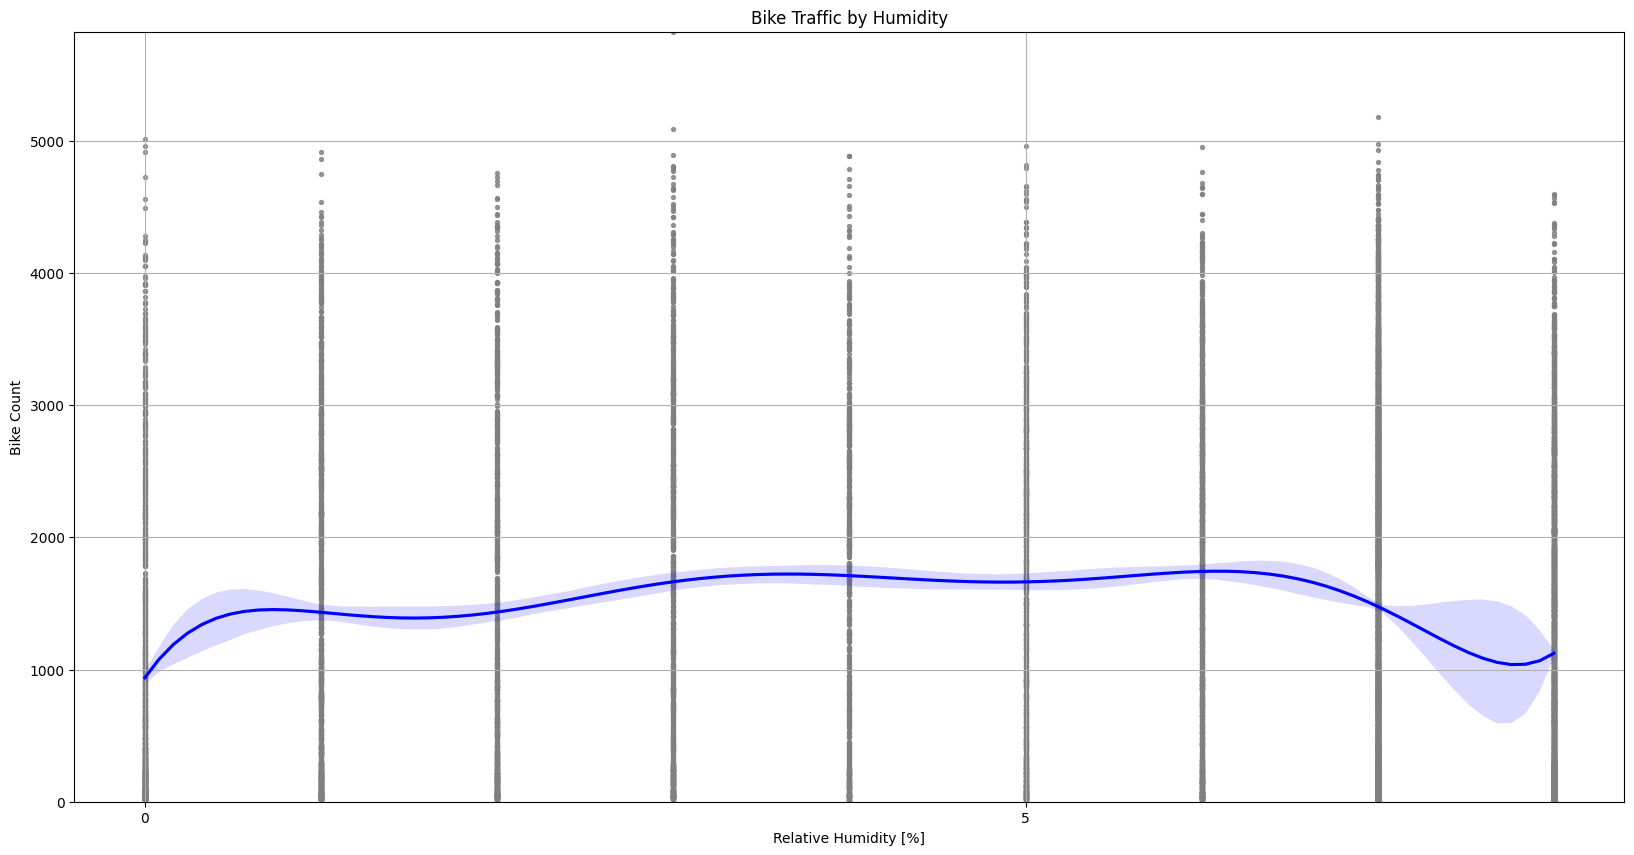

In [54]:
data = merged[merged['clouds_vn'] > -1]
plot_bikes_and('clouds_vn', 'Relative Humidity [%]', 'Bike Traffic by Humidity', data)

TODO KOMMENTAR

In [56]:
# MAYBE 2d HEATMAP PLOT?

TODO KOMMENTAR

## 6. Conclusion

The exploration in this notebook showed that there are certain trends and dependencies to be noticed. Most impactful on the bike traffic is the temperature value. Other big influences include precipitation and wind speed. While these dependencies all behaved as you would expect (e.g. higher precipitation = fewer bikes), it is important to keep in mind that the weather phenomenon might not have always been the cause of the increase or decline of traffic at any given moment. They might also share a common root cause like for instance the time of year. There are less bikes on the streets during winter and average air temperature is lower during winter. Now is the traffic low because of the temperature or because of the time of year? We cannot tell for sure, at least with our limited dataset.

That's why for the future it would be interesting to look at those dependencies and trends with a broader dataset, preferrably using data from different places all over the world. By getting more diverse data, situations like the one discussed earlier could potentially be solved and more accurate models be created.

Another goal for the future would be to collect and utilize data about other means of transportation (cars, public transport, walking, etc.) to see if during times where bike traffic is low, people just get around less and stay at home or if they switch to other transport options. This would again allow us to make more sophisticated claims as we could tell apart general trends from transport medium shifts.

One final idea for the future would include training neural networks on our dataset. Those networks, once trained properly, are much more capable at finding patterns in large sets of data than us humans are. This way we could find connections and correlations between multiple factors that would take ages to find by hand. For example there could be a huge increase of traffic if the precipitation during the day is exactly 0.01% of the average view distance on that same day. Without specifically looking for this however, it would almost be impossible to find. A neural network would help in this scenario.

To sum up, our limited data allowed us a great, but only moderately insightful overview over the correlations between weather and bike traffik. We saw trends we predicted from our own experiences and also discovered a number of interesting new connections in the two datasets. Options to increase quality and usefulness in the future were provided and discussed. The scripts to download, massage, interpret and visualise the data are provided.